In [1]:
import time

import pandas as pd
import matplotlib.pyplot as plt
import rq
from redis import Redis
from tqdm.autonotebook import tqdm
import tasks
import blinq
import seaborn as sns

/tmp/ipykernel_158/1230166008.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
RQ_POLL_INTERVAL = 0.01
RQ_REDIS_CONN = Redis(host='redis')

In [3]:
# Rq.
def rv_rq():
    rq_queue = rq.Queue(connection=RQ_REDIS_CONN)
    rq_job = rq_queue.enqueue(tasks.tracked_sleep)
    rq_result = None
    while True:
        rq_result = rq_job.latest_result()
        if rq_result:
            break
        else:
            time.sleep(RQ_POLL_INTERVAL)

    return rq_result.return_value
print(rv_rq())

{'task_started_at': 1686949090.1669452, 'task_ended_at': 1686949091.1670344}


In [4]:
# Huey.
def rv_huey():
    huey_result = tasks.tracked_sleep_huey()
    return huey_result(blocking=True)
print(rv_huey())

{'task_started_at': 1686949091.1927242, 'task_ended_at': 1686949092.1927884}


In [5]:
# Dramatiq redis.
def rv_dramatiq_redis():
    dramatiq_result = tasks.tracked_sleep_dramatiq_redis.send()
    return dramatiq_result.get_result(backend=tasks.dramatiq_backend_redis, block=True)
print(rv_dramatiq_redis())

{'task_started_at': 1686949092.5107365, 'task_ended_at': 1686949093.510831}


In [6]:
# Dramatiq rmq.
def rv_dramatiq_rmq():
    dramatiq_result = tasks.tracked_sleep_dramatiq_rmq.send()
    return dramatiq_result.get_result(backend=tasks.dramatiq_backend_rmq, block=True)
print(rv_dramatiq_rmq())

{'task_started_at': 1686949093.5518796, 'task_ended_at': 1686949094.5520015}


In [7]:
# Celery redis.
def rv_celery_redis():
    celery_result = tasks.tracked_sleep_celery_redis.delay()
    return celery_result.get()
print(rv_celery_redis())

{'task_started_at': 1686949094.6228726, 'task_ended_at': 1686949095.6230013}


In [8]:
# Celery rmq.
def rv_celery_rmq():
    celery_result = tasks.tracked_sleep_celery_rmq.delay()
    return celery_result.get()
print(rv_celery_rmq())

{'task_started_at': 1686949095.6771982, 'task_ended_at': 1686949096.6772864}


In [9]:
# Blink
def rv_redis():
    blinq_result = blinq.enqueue(payload='tracked_sleep')
    return blinq_result.block_for_return_value()
print(rv_redis())

{'task_started_at': 1686949096.7052553, 'task_ended_at': 1686949097.7054024}


In [10]:
# Do analysis.
records = []
MAX_N_TRIALS = 100

for i_trial in tqdm(range(MAX_N_TRIALS)):
    
    functions = [
        rv_rq, rv_huey, rv_dramatiq_redis, rv_dramatiq_rmq, rv_celery_redis, rv_celery_rmq, rv_redis,
    ]
    
    for function in functions:
        record = {}
        record['name'] = function.__name__[3:]
        record['i_trial'] = i_trial
        record['enqueued_at'] = time.time()
        return_value = function()
        record['returned_at'] = time.time()
        record = record | return_value
        records.append(record)
        
        
df = pd.DataFrame.from_records(records)
df.head()

  0%|          | 0/100 [00:00<?, ?it/s]

,name,i_trial,enqueued_at,returned_at,task_started_at,task_ended_at
0,rq,0,1.686949e+09,1.686949e+09,1.686949e+09,1.686949e+09
1,huey,0,1.686949e+09,1.686949e+09,1.686949e+09,1.686949e+09
2,dramatiq_redis,0,1.686949e+09,1.686949e+09,1.686949e+09,1.686949e+09
3,dramatiq_rmq,0,1.686949e+09,1.686949e+09,1.686949e+09,1.686949e+09
4,celery_redis,0,1.686949e+09,1.686949e+09,1.686949e+09,1.686949e+09


In [11]:
df = df[df.i_trial != 0]
df['slept_for'] = df.task_ended_at - df.task_started_at
df['latency_enqueue'] = (df.task_started_at - df.enqueued_at) * 1000
df['latency_result'] = (df.returned_at - df.task_ended_at) * 1000
df['latency_total'] = df.latency_enqueue + df.latency_result

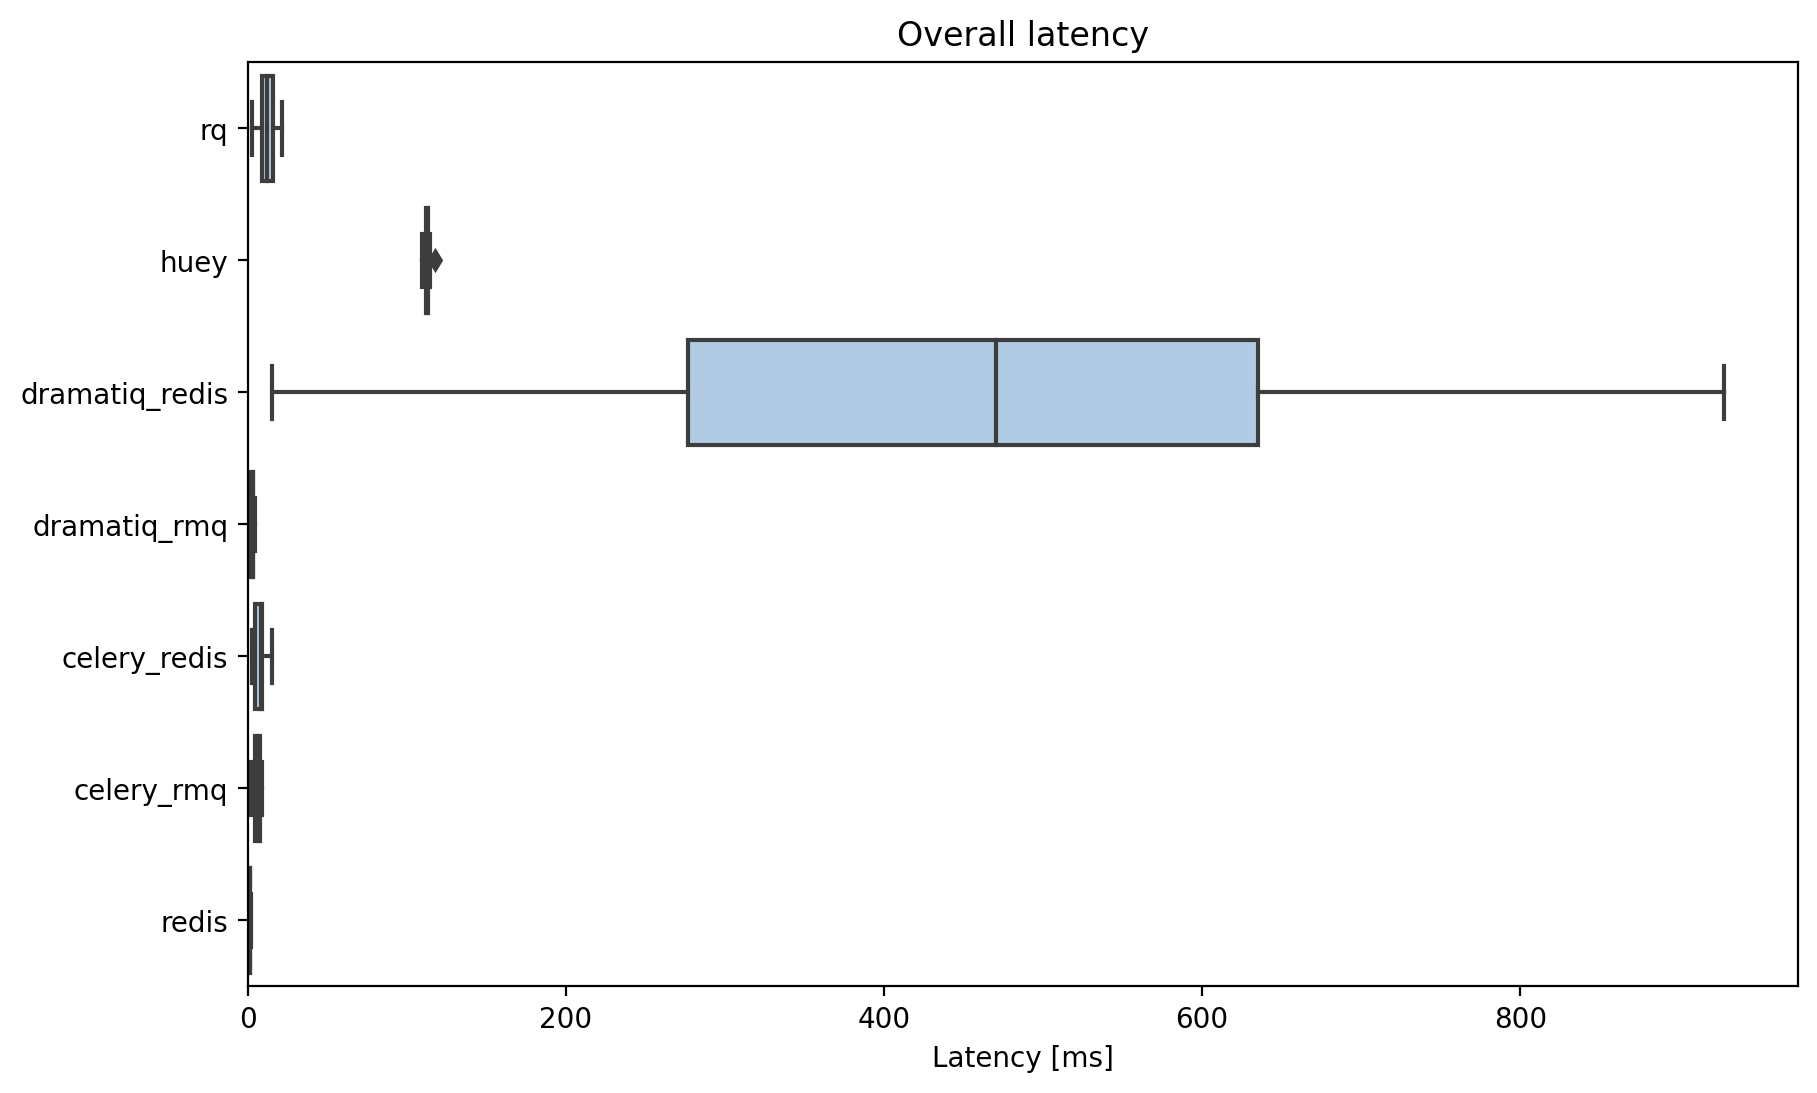

In [12]:
fig, ax = plt.subplots(dpi=200, figsize=(10, 6))
sns.boxplot(df, y='name', x='latency_total', boxprops={"facecolor": (.4, .6, .8, .5)})
ax.set_title('Overall latency')
ax.set_xlabel('Latency [ms]')
ax.set_ylabel('')
ax.set_xlim(left=0);

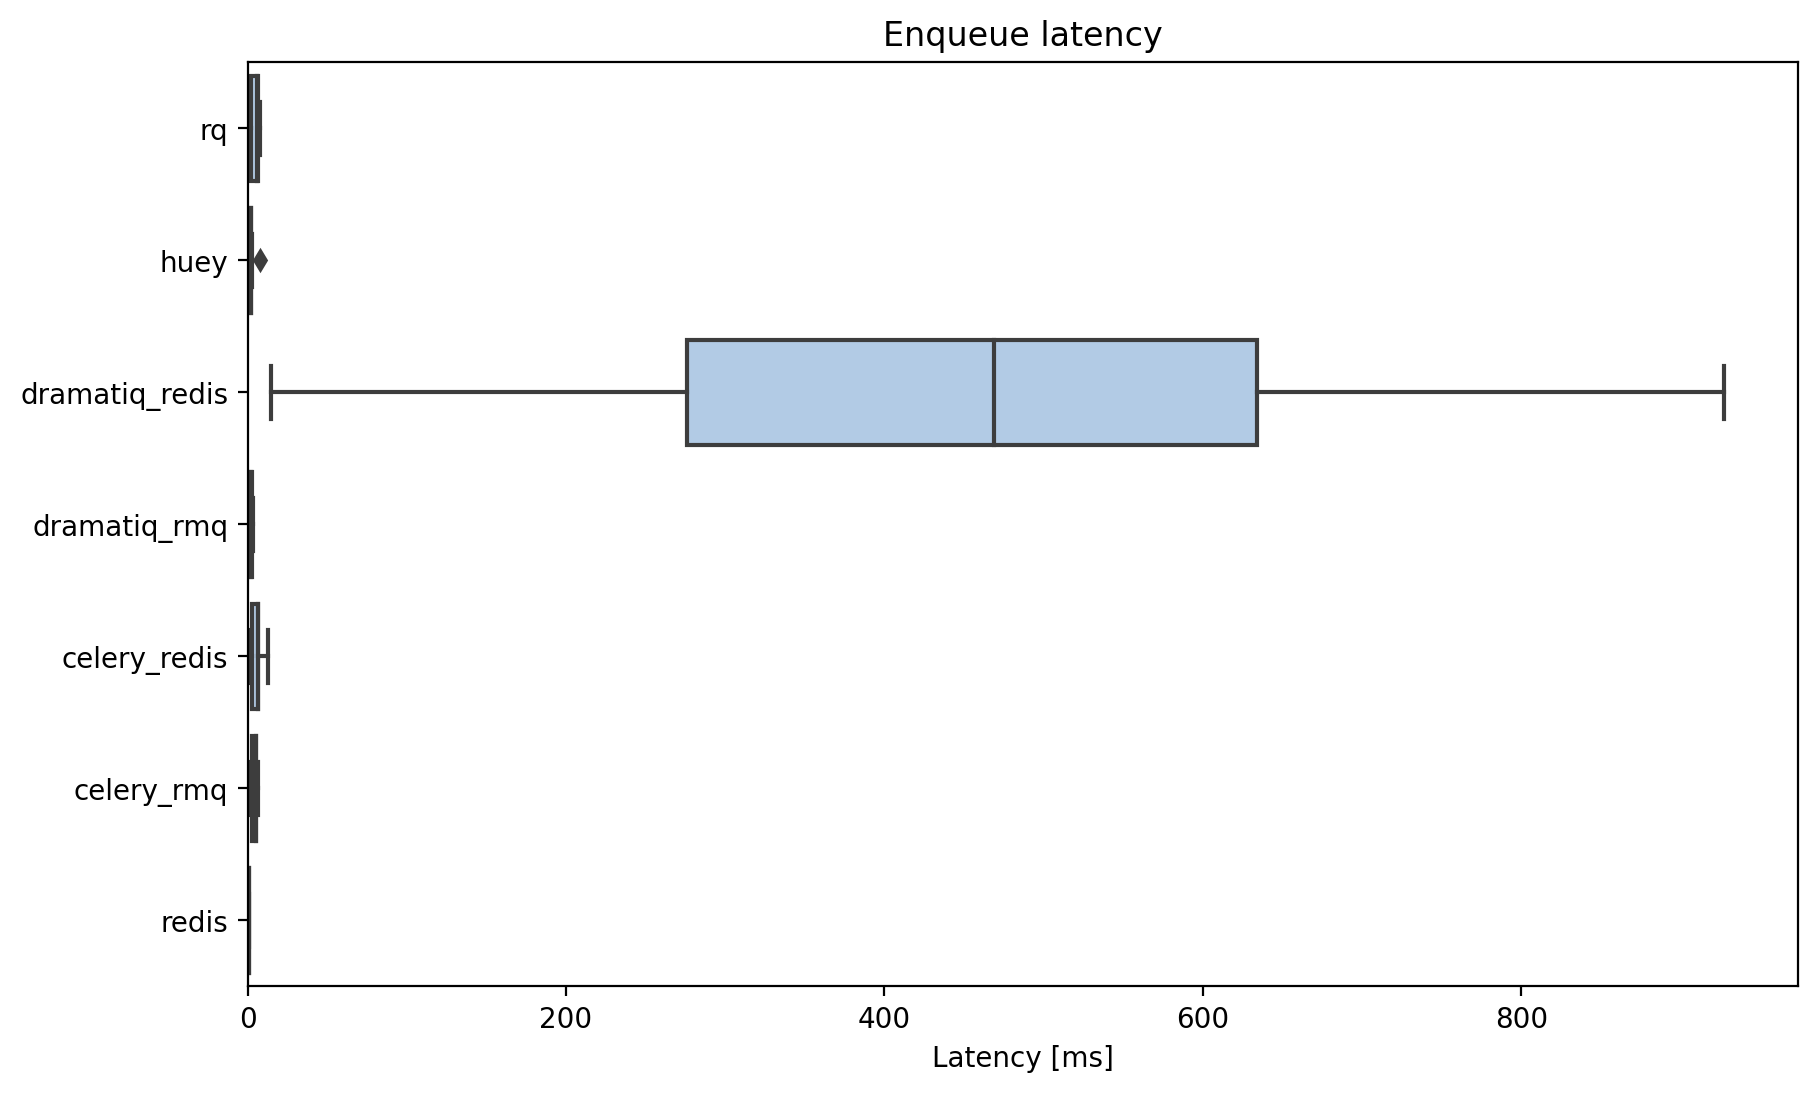

In [13]:
fig, ax = plt.subplots(dpi=200, figsize=(10, 6))
sns.boxplot(df, y='name', x='latency_enqueue', boxprops={"facecolor": (.4, .6, .8, .5)})
ax.set_title('Enqueue latency')
ax.set_xlabel('Latency [ms]')
ax.set_ylabel('')
ax.set_xlim(left=0);

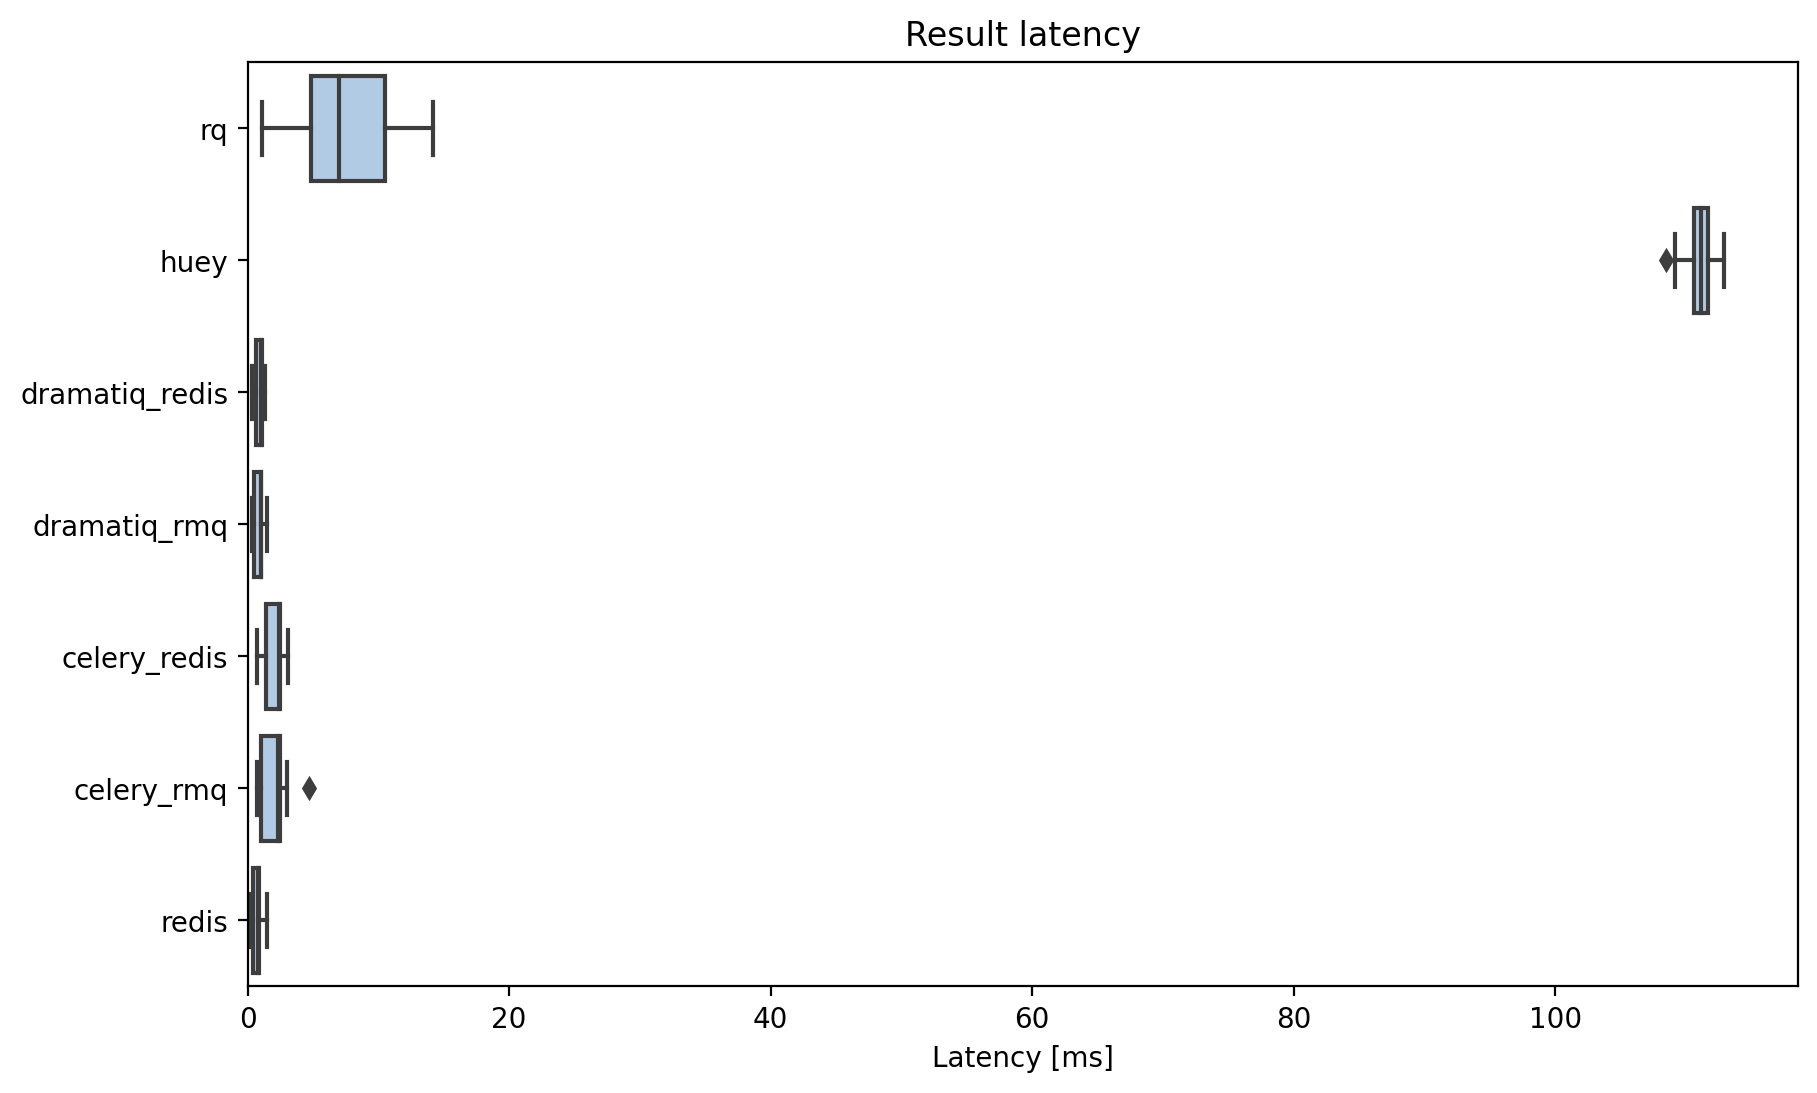

In [14]:
fig, ax = plt.subplots(dpi=200, figsize=(10, 6))
sns.boxplot(df, y='name', x='latency_result', boxprops={"facecolor": (.4, .6, .8, .5)})
ax.set_title('Result latency')
ax.set_xlabel('Latency [ms]')
ax.set_ylabel('')
ax.set_xlim(left=0);

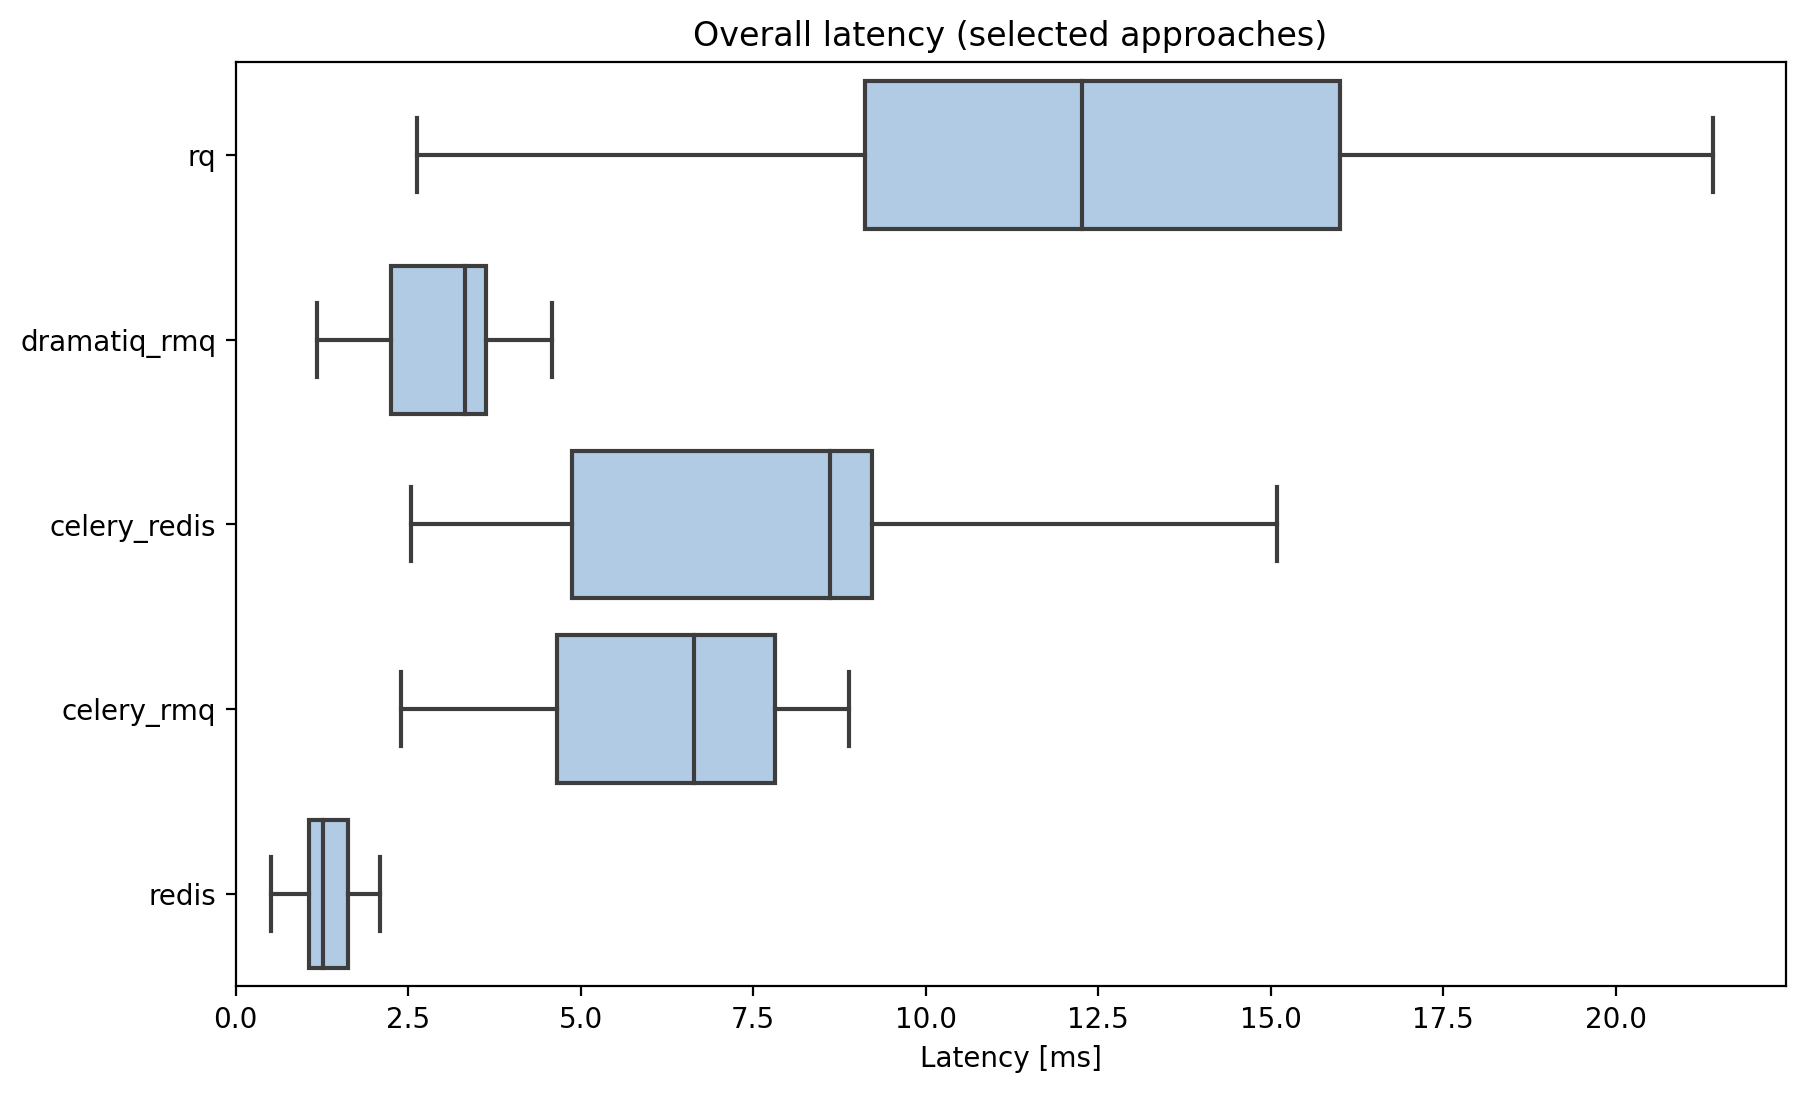

In [19]:
df_fast = df[~df.name.isin({'dramatiq_redis', 'huey'})]
fig, ax = plt.subplots(dpi=200, figsize=(10, 6))
sns.boxplot(df_fast, y='name', x='latency_total', boxprops={"facecolor": (.4, .6, .8, .5)})
ax.set_title('Overall latency (selected approaches)')
ax.set_xlabel('Latency [ms]')
ax.set_ylabel('')
ax.set_xlim(left=0);

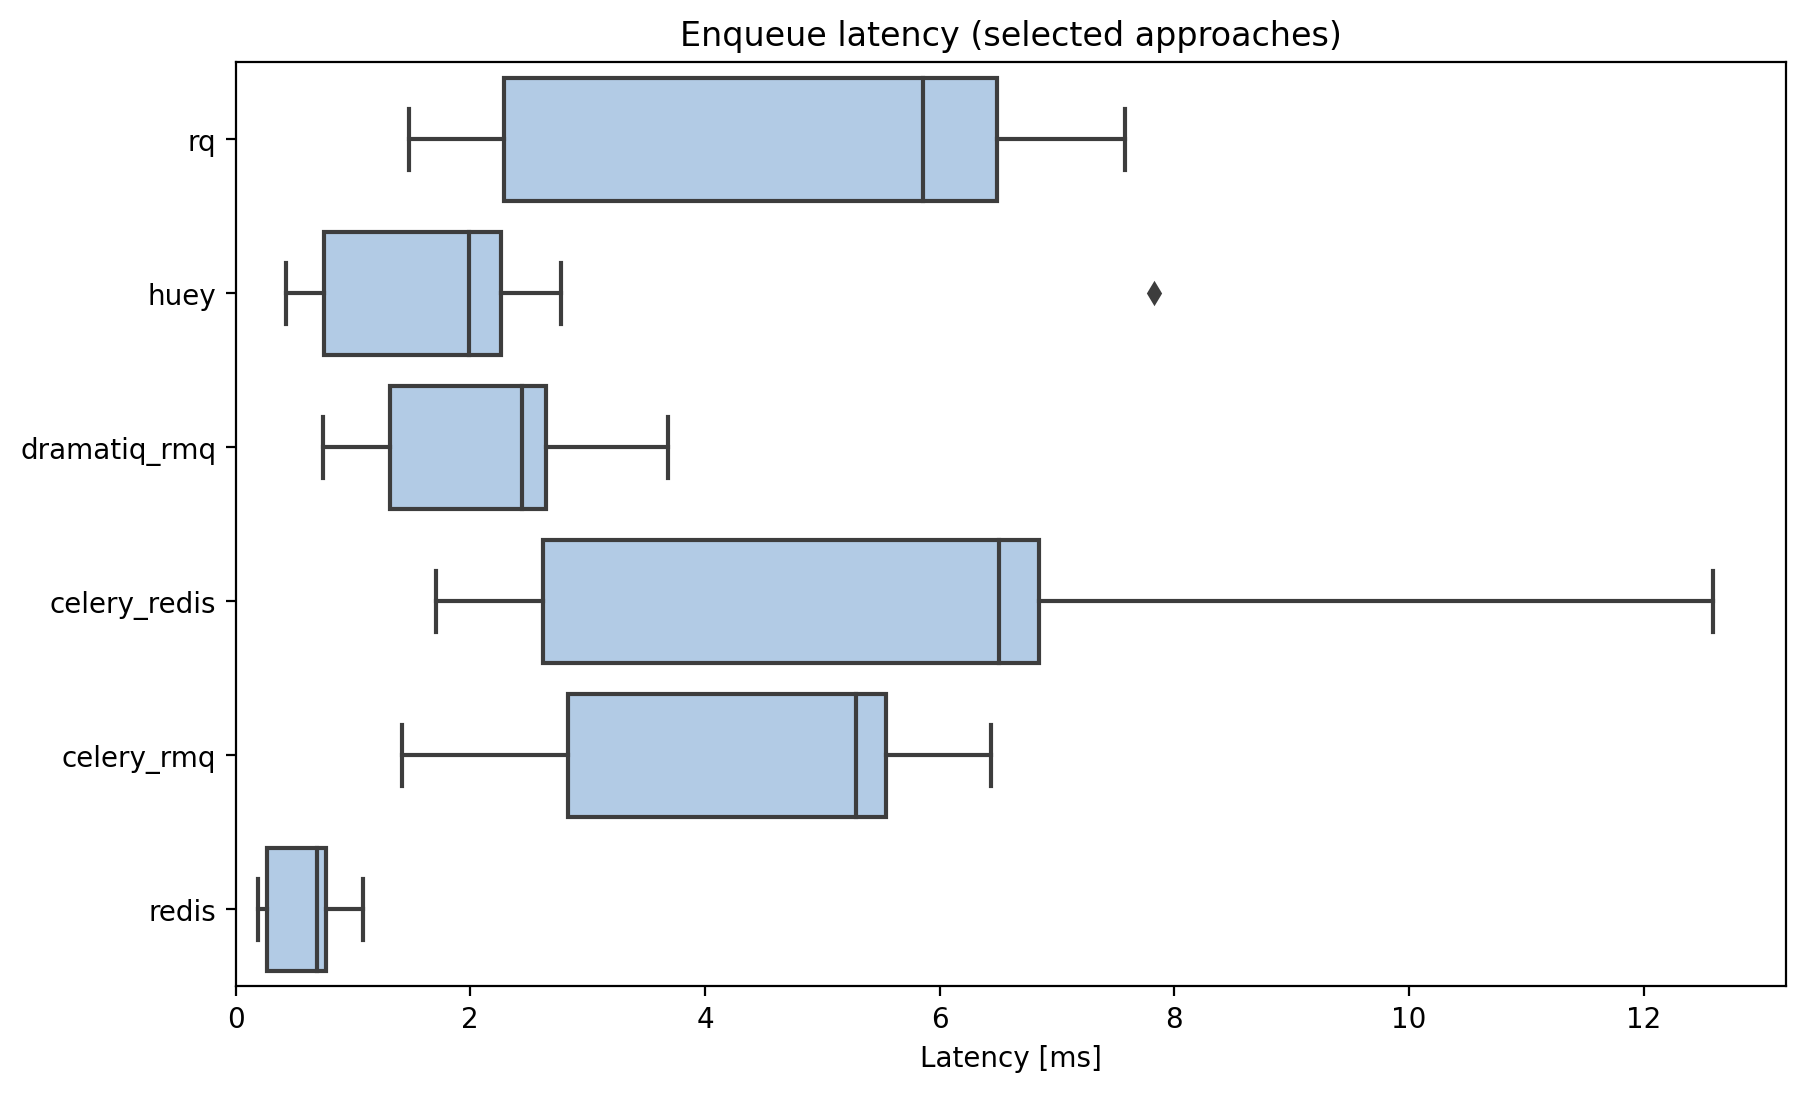

In [16]:
df_fast = df[~df.name.isin({'dramatiq_redis'})]
fig, ax = plt.subplots(dpi=200, figsize=(10, 6))
sns.boxplot(df_fast, y='name', x='latency_enqueue', boxprops={"facecolor": (.4, .6, .8, .5)})
ax.set_title('Enqueue latency (selected approaches)')
ax.set_xlabel('Latency [ms]')
ax.set_ylabel('')
ax.set_xlim(left=0);

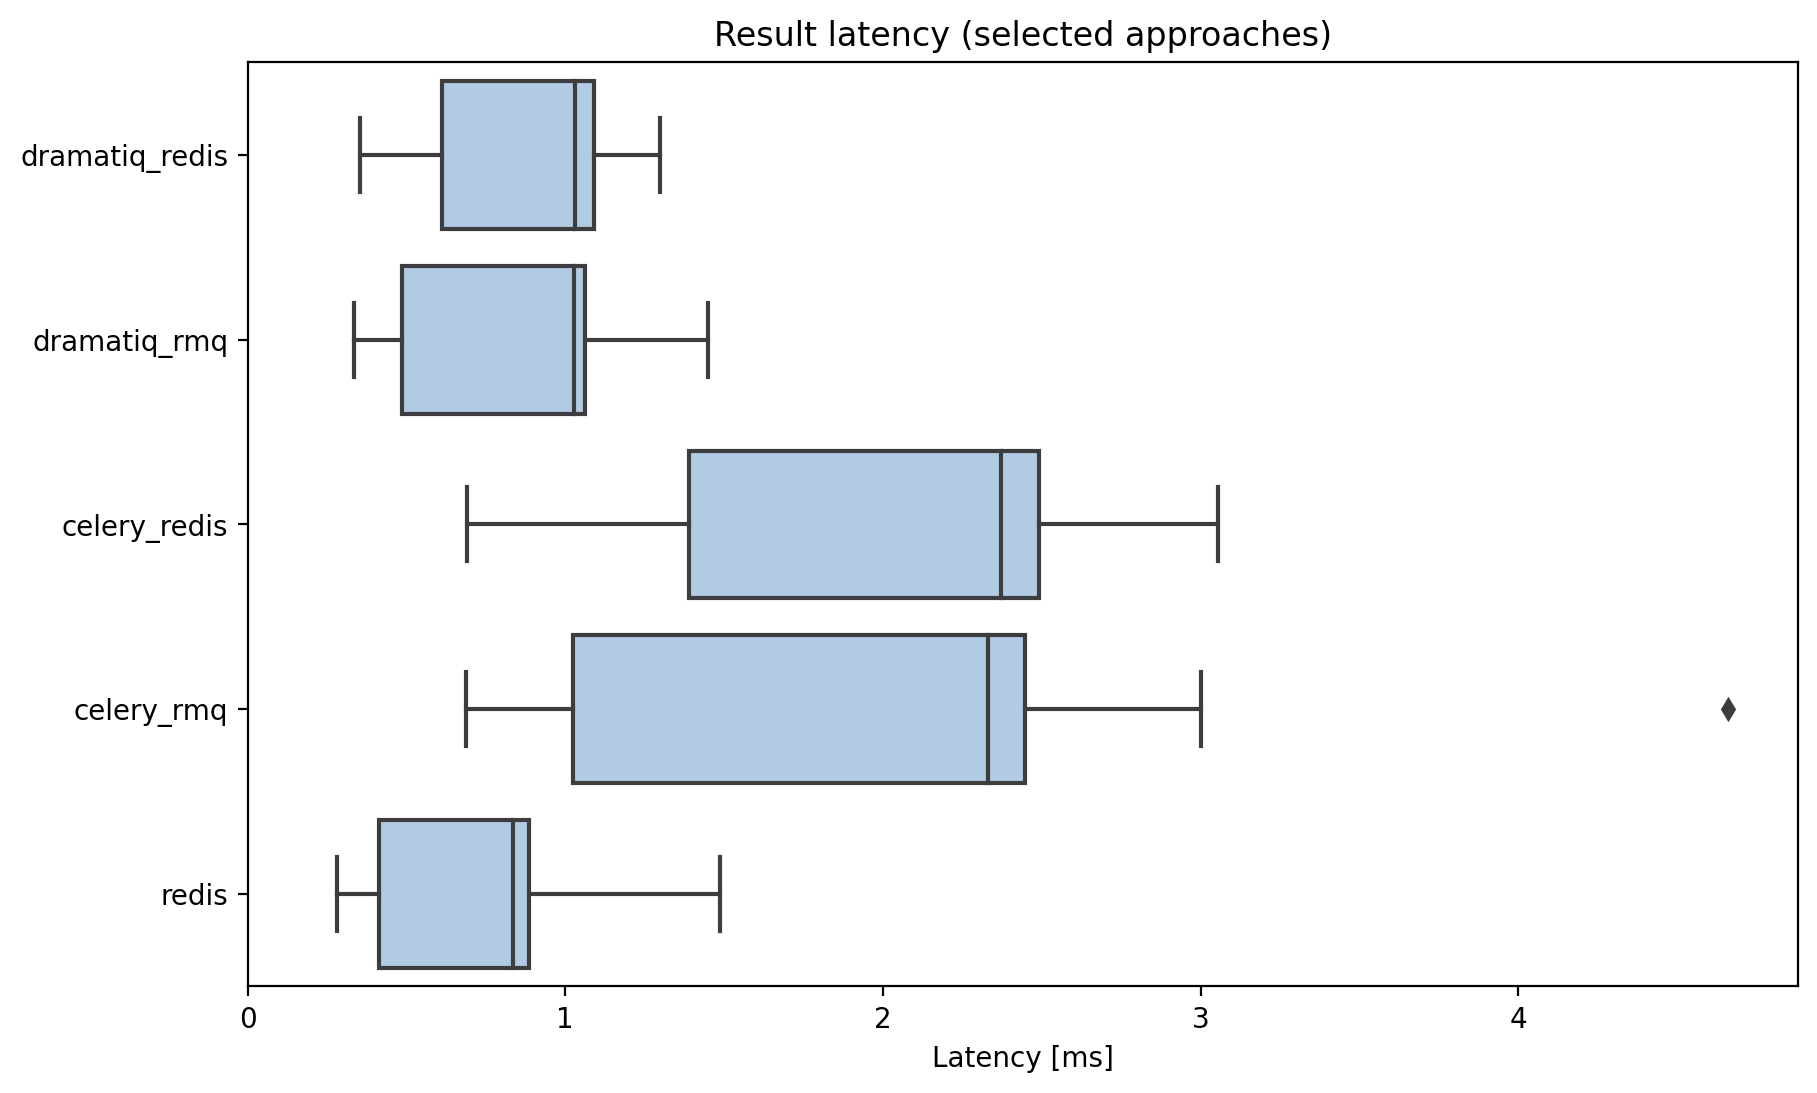

In [17]:
df_fast = df[~df.name.isin({'rq', 'huey'})]
fig, ax = plt.subplots(dpi=200, figsize=(10, 6))
sns.boxplot(df_fast, y='name', x='latency_result', boxprops={"facecolor": (.4, .6, .8, .5)})
ax.set_title('Result latency (selected approaches)')
ax.set_xlabel('Latency [ms]')
ax.set_ylabel('')
ax.set_xlim(left=0);